In [1]:
#importacion de librerias necesarias

import numpy as np #para trabajar con arrays numéricos.
import matplotlib.pyplot as plt #para hacer gráficos de entrenamiento como curvas de accuracy y loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator #para cargar imágenes desde carpetas y aplicar transformaciones automáticas (como escalado, rotación
from tensorflow.keras.models import Sequential #definir un modelo de red neuronal secuencial (capas apiladas una detrás de otra).
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,BatchNormalization #importa las capas necesarias para construir la CNN
from tensorflow.keras.optimizers import Adam  #optimizador que ajusta los pesos del modelo, probamos con Adam primero
from sklearn.metrics import classification_report, confusion_matrix #Para evaluar el rendimiento del modelo una vez que ha hecho predicciones
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#lECTURA DE NUESTROS DATOS Y FIJAMOS VARIABLES
img_size = 48 #definimos una variable para fijar el tamaño (alto y ancho) al que se redimensionarán todas las imágenes antes de pasarlas por la red neurona
batch_size = 32 # sacado de la literatura es el número de imágenes que el modelo procesará a la vez antes de actualizar los pesos - un EPOCH o paso de entrenamiento
epochs = 30 #cuántas veces el modelo verá todo el dataset completo de entrenamiento - lo usaremos en el .fit
ruta_train = r"C:\Users\anaco\Downloads\data\archive\train"
ruta_test = r"C:\Users\anaco\Downloads\data\archive\test"    

In [3]:
#TRATAMIENTO DE IMAGENES
#Leer las imágenes manualmente desde carpetas.

#Convertirlas a escala de grises, redimensionarlas a 48x48.

#Almacenar las imágenes en X_train, y las etiquetas como números en y_train (nuestras Y van a ser las emociones que queremos predecir, pero en formato numerico).

#Normalizar las imágenes a [0, 1].

import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# LISTA MANUAL DE ETIQUETAS (según nuestras carpetas)
etiquetas = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Creamos una función para cargar imágenes desde una ruta base, porque tendremos que aplicar esto a nuestras fotos de train y fotos de test
def cargar_imagenes_y_etiquetas(ruta_base, etiquetas, img_size):
    X = []
    y = []
    for etiqueta in etiquetas:
        ruta_carpeta = fr"{ruta_base}\{etiqueta}\*.jpg"
        for ruta_imagen in glob.glob(ruta_carpeta):
            try:
                img = Image.open(ruta_imagen).convert("L").resize((img_size, img_size))
                X.append(np.array(img))
                y.append(etiqueta)
            except Exception as e:
                print(f"Error en {ruta_imagen}: {e}")
    X = np.array(X).reshape(-1, img_size, img_size, 1).astype("float32") / 255.0
    y = np.array(y)
    return X, y

# Cargar TRAIN
X_train, y_train_raw = cargar_imagenes_y_etiquetas(ruta_train, etiquetas, img_size)

# Cargar TEST
X_test, y_test_raw = cargar_imagenes_y_etiquetas(ruta_test, etiquetas, img_size)

# Codificar etiquetas en números
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)  # usar el mismo encoder

# Confirmar formas y carga correcta de datos
print(f"imagenes de entrenamiento normalizadas: {X_train.shape} | etiquetas codificadas: {y_train.shape}")
print(f"imagenes de test normalizadas: {X_test.shape}  | etiquetas codificadas para test: {y_test.shape}")
print("Clases:", le.classes_)

imagenes de entrenamiento normalizadas: (28709, 48, 48, 1) | etiquetas codificadas: (28709,)
imagenes de test normalizadas: (7178, 48, 48, 1)  | etiquetas codificadas para test: (7178,)
Clases: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


Conclusion: con esos resultados confirmamos que la carga y preprocesamiento del dataset fue un éxito total

Por curiosidad y totalmente opcional 
vamos a visualizar una imagen normal vs normalizada. 
Visualmente ambas imágenes se ven igual, porque el ojo no distingue 
entre escala [0–255] y [0–1] si el contraste relativo es el mismo
Pero internamente, los valores de la imagen normalizada están entre 0 y 1, 
y eso es clave para el entrenamiento del modelo

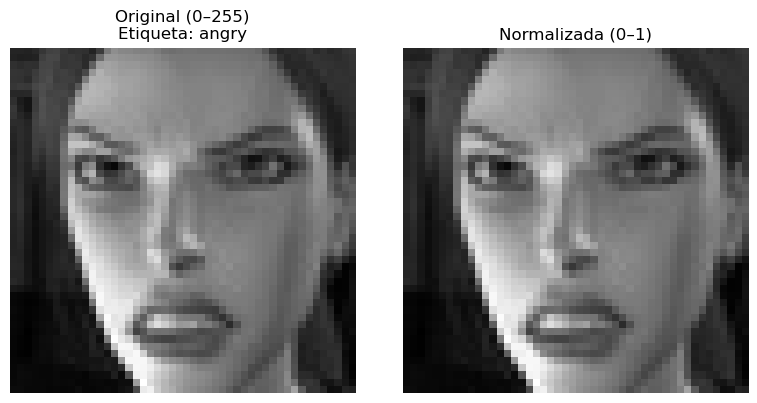

In [4]:
# Seleccionamos una imagen (la 5, por ejemplo)
imagen_normalizada = X_train[5]
etiqueta_codificada = y_train[5]
etiqueta_texto = le.inverse_transform([etiqueta_codificada])[0] # usamos .inverse_transform() para convertir de número a texto (por ejemplo, 4 → 'happy').

# Para comparación, recreamos la imagen original (des-normalizada)
imagen_original = imagen_normalizada * 255

# Convertir a 2D para mostrar
original_2d = imagen_original.reshape(img_size, img_size)
normalizada_2d = imagen_normalizada.reshape(img_size, img_size)

# Dibujar graficamente
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_2d, cmap='gray')
plt.title(f"Original (0–255)\nEtiqueta: {etiqueta_texto}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(normalizada_2d, cmap='gray')
plt.title("Normalizada (0–1)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
#Creamos ahora un modelo de 4 capas CON2D con aumento progrsivo de neuronas par aun efecto lupa
#añadimos tambien batchNormalizacion como en clase


# Número de clases
num_clases = len(np.unique(y_train))  # 7

# Definimos el modelo
model = Sequential([
    # 1ª capa convolucional
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 2ª capa convolucional
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 3ª capa convolucional
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 4ª capa convolucional
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Regularización
    Dropout(0.4),

    # Clasificación
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(num_clases, activation='softmax')
])

# Compilamos el modelo con sparse categorical_crossentropy (usamos Adam W ya que vimos en un modelo de HuggingFace que se recomendaba)
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4, epsilon=1e-7),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Text(0, 0.5, 'Cantidad de imágenes')

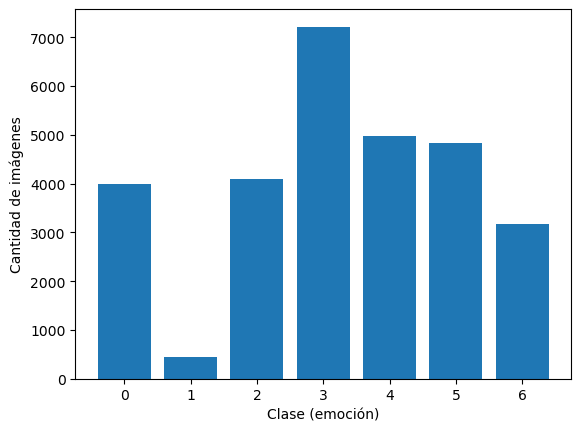

In [6]:
#revisamos el desbalance de clases 
classes, counts = np.unique(y_train, return_counts=True)
plt.bar(classes, counts)
plt.xlabel("Clase (emoción)")
plt.ylabel("Cantidad de imágenes")

Ya hemos visto que nuestras clases estan desbalanceadas. Vamos a aplicar tecnicas de data augmentation en la parte del codigo de abajo

Primero: Detectamos qué clases tienen menos imágenes.

Segundo: Creamos nuevas imágenes para esas clases, aplicando transformaciones visuales (data augmentation).

Tercero: Mezclamos esas nuevas imágenes que hemos creado con las originales.

Luego entrenamos la red neuronal con un conjunto mas equilibrado comparando los resultados con el modelo anterior sin DA

In [7]:
from collections import Counter #en la literatura hemos encontrado esta funcion que nos permite contar cuántas imágenes hay por clase.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #es la funcion de Keras que aplica transformaciones a las imágenes para crear versiones nuevas.

# Contamos cuántas imágenes hay por clase
conteo_clases = Counter(y_train)
max_count = max(conteo_clases.values()) #obtenemos el número de la clase mayoritaria (max_count).
#Esto nos sirve para saber cuántas imágenes debemos generar para igualar las clases minoritarias, y lo guardamos en una variable que usaremos cuando aumentemos las clases.

# Crear generador de augmentación, configurandolo con las modificaciones que queremos hacer a las imagenes creadas
datagen = ImageDataGenerator(
    rotation_range=15, #Rota aleatoriamente la imagen entre -15 y +15 grados
    width_shift_range=0.05,  # Desplaza horizontalmente la imagen hasta un 5% del ancho
    height_shift_range=0.05, # Desplaza verticalmente hasta un 5% de la altura
    zoom_range=0.1, # Hace zoom aleatorio dentro del 90%-110% del tamaño
    horizontal_flip=True,# Invierte 180 grados la imagen (efecto espejo)
    fill_mode='nearest' # Rellena los píxeles nuevos usando el valor más cercano
)

# Crear listas para guardar las nuevas imágenes augmentadas
X_augmented = []
y_augmented = []

# Aumentar solo las clases minoritarias
for clase, count in conteo_clases.items():
    if count < max_count:
        num_to_generate = max_count - count
        indices = np.where(y_train == clase)[0]
        X_clase = X_train[indices]

        for i in range(num_to_generate):
            idx = i % len(X_clase)
            image = X_clase[idx]
            image = np.expand_dims(image, 0)
            for batch in datagen.flow(image, batch_size=1):
                X_augmented.append(batch[0])
                y_augmented.append(clase)
                break

# Combinar con datos originales
X_train = np.concatenate([X_train, np.array(X_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])

# Confirmar que ahora todas las clases tienen el mismo número de imágenes
from collections import Counter
print("Conteo de clases tras data augmentation:", Counter(y_train))

Conteo de clases tras data augmentation: Counter({0: 7215, 1: 7215, 2: 7215, 3: 7215, 4: 7215, 5: 7215, 6: 7215})


In [8]:
# Entrenamos el modelo directamente con y_train e y_test
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "modelo_complejo_data_augm.h5",
    save_best_only=True,
    monitor="val_loss",
    verbose=1
)

# Entrenamiento
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
1579/1579 [==============================] - ETA: 0s - loss: 1.8088 - accuracy: 0.3132
Epoch 1: val_loss improved from inf to 1.55746, saving model to modelo_complejo_data_augm.h5
1579/1579 [==============================] - 255s 153ms/step - loss: 1.8088 - accuracy: 0.3132 - val_loss: 1.5575 - val_accuracy: 0.3821
Epoch 2/30
1579/1579 [==============================] - ETA: 0s - loss: 1.1545 - accuracy: 0.5660
Epoch 5: val_loss improved from 1.18389 to 1.14853, saving model to modelo_complejo_data_augm.h5
1579/1579 [==============================] - 246s 156ms/step - loss: 1.1545 - accuracy: 0.5660 - val_loss: 1.1485 - val_accuracy: 0.5603
Epoch 6/30
1579/1579 [==============================] - ETA: 0s - loss: 1.1026 - accuracy: 0.5873
Epoch 6: val_loss did not improve from 1.14853
1579/1579 [==============================] - 231s 147ms/step - loss: 1.1026 - accuracy: 0.5873 - val_loss: 1.2778 - val_accuracy: 0.5327
Epoch 7/30
1579/1579 [==============================] - ET

KeyboardInterrupt: 

El modelo siguió aprendiendo en entrenamiento, pero perdió capacidad de generalizar en validación después de la epoch 15.

Desde epoch 16 en adelante, el modelo memoriza pero ya no mejora, e incluso empeora en val_accuracy y val_loss, sugiriendo un claro overfitting

Entonces, aplicaremos un EarlyStopping(patience=3) para que se detenga automáticamente cuando val_loss deje de mejorar.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicción
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Reporte por clase
print("🔍 Clasification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

Interpretacion de los resultados:
happy es muy dominante → casi todas las clases tienden a confundirse con ella.

fear se reparte: mucha confusión con neutral, sad y surprise.

sad se confunde muchísimo con neutral (492), pero también con angry.

disgust es pequeña y se reparte en múltiples predicciones.

La arquitectura de 4 capas + AdamW + BatchNormalization funciona.

happy, surprise, neutral están bastante bien.
angry, fear, disgust, sad  requieren atención especial para mejorar el modelo


